# To Churn or Not to Churn

## Goal: 
* Discover what is driving people to leave.
* Create a model to predict when people are going to leave.

## Imports

In [1]:
import wrangle as wr
import explore as ex
import stats_conclude as sc
import evaluate as ev
import scipy.stats as stats
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

> # `Wrangle`

### Acquire
* Data acquired from mySQL Codeup Server using env.py credentials
* It contained 7,043 rows and 24 columns before cleaning
* Each row represents a customer
* Each column represents a feature of either the customer or the business

### Prepare
Prepare Actions:

* Checked that column data types were appropriate
    * changed total_charges from an object to a float
* Checked for nulls in the data (there were 11)
    * total_charges contained 11 nulls for new customers.
    * imputed the corresponding monthly_charges value to the total_charges nulls
* Encoded categorical variables
* Split data into train, validate and test (approx. 60/20/20)
    * target = 'churn'
* Outliers have not been removed for this iteration of the project

### Data Dictionary


| Feature | Definition |
|:--------|:-----------|
|Churn|  Whether or not a customer has churned **(target)**|
|Phone Service| Whether or not the customer has a phone line|
|Internet Service Type| Customer's type of internet (Fiber optic **(focus)**, DSL, None)|
|Total Charges| The total charges a customer has paid|
|Contract Type| Customer contract type (Month-to-month **(focus)**, One year, Two year)|
|Multiple Lines| Whether a customer has more than one line|

In [2]:
# acquiring data
df = wr.get_telco_churn()

# cleaning data and saving to a clean_df
df_clean = wr.clean_telco(df)

# splitting data - returns shape to verify proper split sizes
train, validate, test = wr.split_telco(df_clean)


csv file found and loaded
Load in successful, awaiting commands...
Prepared DF: (7043, 28)
Train: (4225, 28)
Validate: (1409, 28)
Test: (1409, 28)


> # `Explore`

### Questions To Answer:
1. Is phone service and fiber internet related in any way?

2. From a revenue standpoint, where should we focus our initial efforts?

3. Are month to month contracts causing churn? Why?

4. Were average monthly charges higher for churned members?

---
### Fiber Internet:
* 62% of all internet revenue
    * totaling $9,923,622.95 
    * 3,096 customers = 44% of total customer base
    
    
### Interesting Note:
* All Fiber customers have Phone Service!
* Since these are related, and phone service provides 15 billion in revenue, I decided to look deeper...
---

## 1. Are Fiber and Phone Related?

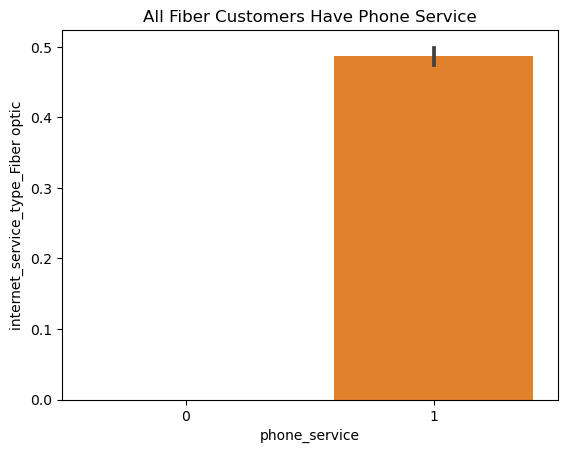

In [3]:
ex.phone_fiber(df_clean)

### Using Chi^2 Testing:

In [4]:
observed = pd.crosstab(df_clean.phone_service, 
                       df_clean['internet_service_type_Fiber optic'])

In [5]:
sc.chi2_test(observed)

----
We reject the null hypothesis. Phone and Fiber are related.


## 2. From a revenue standpoint, where should we focus our initial efforts?

Since phone and fiber are related, what happens to phone customers affects fiber numbers as well resulting in large profit losses.

### **PHONE**

* 94% of phone revenue comes from phone service
    * totaling $15,035,873.75
    
    * 6,361 customers = 90% of total customer base
    
    * Churn rate of **96%** for monthly phone contracts has lost Telco:
        * **$2,600,062.40**
        * 1,297 customers
    
---    
 
### **FIBER**  
* 62% of all internet revenue
    * totaling $9,923,622.95 
    * 3,096 customers = 44% of total customer base
    
---
**|DIFFERENCE PHONE|** Churn V Not Churn
* **43%** churn rate
* **$12.55** higher monthly average

* 25th percentile:  **$24.31** higher/month

* 50th percentile:  **$10.30** higher/month

* 75th percentile:  **$7.33** higher/month

---

**|DIFFERENCE: MONTH-TO-MONTH FIBER|** Churn V Not Churn
* **53.9%** churn rate
* **$-1.21** higher monthly average

* 25th percentile:  **$-8.96** higher/month

* 50th percentile:  **$-2.47** higher/month

* 75th percentile:  **$-0.01** higher/month

---

**|DIFFERENCE: ONE LINE, MONTH-TO-MONTH, PHONE|** Churn V Not Churn
* **38.7%** churn rate
* **$12.95** higher monthly average

* 25th percentile:  **$29.88** higher/month

* 50th percentile:  **$15.95** higher/month

* 75th percentile:  **$6.30** higher/month

The problem isn't with the fiber customers, it's with monthly charges for one-line, month-to-month phone customers because everyone who has fiber... has at least one line of phone service.

## 3. Are month to month phone contracts experiencing churn? Why?

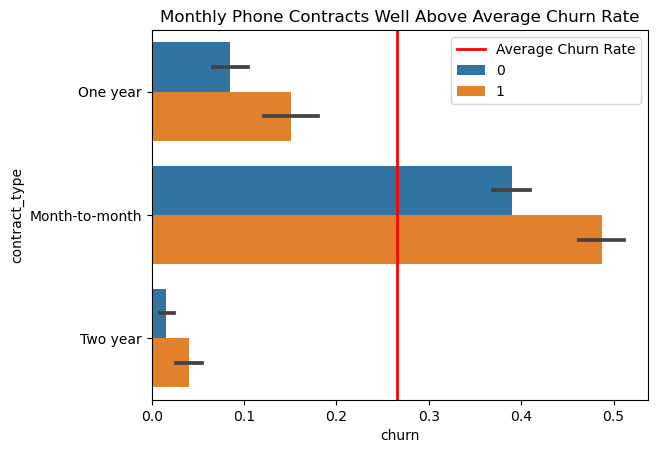

In [6]:
ex.monthly_phone_churn(df_clean)

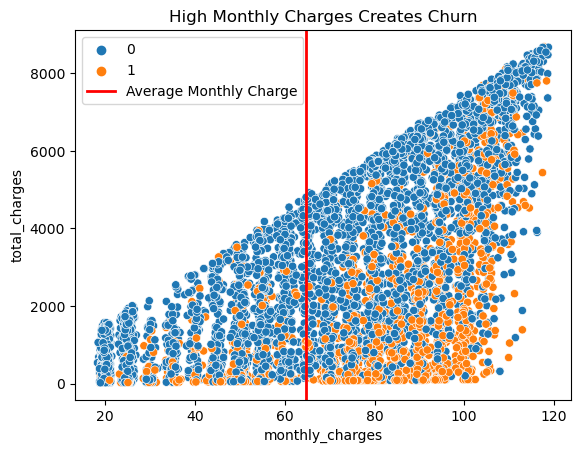

In [7]:
ex.total_monthly(df_clean)

### Statistics Tests

Which test do we use to look at phone service and churn?
* Mann-Whitney U


In [8]:
sc.conclude_mannwhitneyu(df_clean.phone_service, df_clean.churn)

t-stat: 40620502.5
p-value: 0.0 < 0.05?
We reject the null hypothesis.


Which test do we use to look at monthly charges and churn?
* Mann-Whitney U

In [9]:
sc.conclude_mannwhitneyu(df_clean.monthly_charges, df_clean.churn)

t-stat: 49603849.0
p-value: 0.0 < 0.05?
We reject the null hypothesis.


Which test do we use to look at phone service and monthly charges?
* Mann-Whitney U

In [10]:
sc.conclude_mannwhitneyu(df_clean.phone_service, df_clean.monthly_charges)

t-stat: 0.0
p-value: 0.0 < 0.05?
We reject the null hypothesis.


## 4. Were average monthly charges higher for churned phone customers?

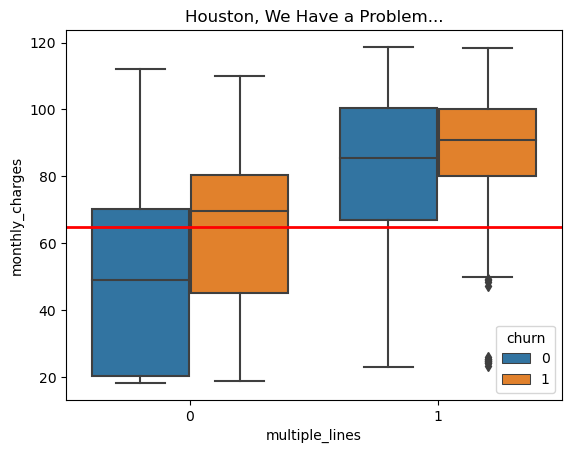

In [11]:
ex.box_plot_monthly_multiple(df_clean)

## Explore Summary

1. Is phone service and fiber internet related in any way?
    * Yes! Directly.

2. From a revenue standpoint, where should we focus our initial efforts?
    * Monthly Contract, One Line, Phone Customers

3. Are month to month contracts causing churn? Why?
    * Yes. Monthly charges were $13 higher for one line, churned phone customers.

4. Were average monthly charges higher for churned members?
    * Across the board, yes. Including those who haven't churned (yet) with more than one line.

### Features to Model:
* Phone Service 
* Internet Service **(focus is on Fiber)**
* Monthly Charges
* Total Charges
* Contract Type **(focus is on Monthly)**
* Multiple Lines **(focus is on One Line)**

> # `Model`

* Accuracy is the evaluation metric
    * Focus is to accurately predict potential churn for this iteration
    
* Positive Case: No Churn (0)
    * Not churning = 5,174 customers
        * 73.5%
    * Churning = 1,869 customers
        * 26.5%
        
        
* Decision Tree: 78%, 80%
* Random Forest: 78%, 80%
* KNN: 79%, 80%
* Logistic Regression: 78%, 79%

### Model to Test
* Accuracy is the evaluation metric
* Random Forest with a max depth of 6 to model.

In [14]:
# MODEL
ev.random_forest_test(test)

This is the Random Forest Model with a Max Depth of 6
and ran on the test set.

For a depth of 6, the accuracy is 0.82

The baseline accuracy is 0.73

              precision    recall  f1-score   support

           0       0.84      0.93      0.88      1035
           1       0.73      0.51      0.60       374

    accuracy                           0.82      1409
   macro avg       0.79      0.72      0.74      1409
weighted avg       0.81      0.82      0.81      1409

The model beats on baseline.


> # `Conclusion`

## Explore

* Reduce cost of monthly contracts for one line phone service customers and we will see results with phone and fiber customers.

## Modeling
* Beat on baseline by 9%

## Recommendations

* Monthly contracts make up the majority of our customer base.

* Let's stop bleeding customers...

In [ ]:
ex.monthly_contract(df_clean)

* There is wiggle room to reduce price for phone customers!

* We can afford to reduce monthly contract price by $10.

In [ ]:
ex.fiber_average_cost(df_clean)